In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed,Input

In [8]:
df = pd.read_csv('NSEI.csv')
print(df[:5])

         Date          Open          High           Low         Close  \
0  2022-04-05  18080.599609  18095.449219  17921.550781  17957.400391   
1  2022-04-06  17842.750000  17901.000000  17779.849609  17807.650391   
2  2022-04-07  17723.300781  17787.500000  17623.699219  17639.550781   
3  2022-04-08  17698.150391  17842.750000  17600.550781  17784.349609   
4  2022-04-11  17740.900391  17779.050781  17650.949219  17674.949219   

      Adj Close  Volume  
0  17957.400391  283500  
1  17807.650391  328800  
2  17639.550781  308800  
3  17784.349609  274400  
4  17674.949219  251700  


In [9]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
238,2023-03-20,17066.599609,17066.599609,16828.349609,16988.400391,16988.400391,241800
239,2023-03-21,17060.400391,17127.699219,17016.000000,17107.500000,17107.500000,246700
240,2023-03-22,17177.449219,17207.250000,17107.849609,17151.900391,17151.900391,0
241,2023-03-23,17097.400391,17205.400391,17045.300781,17076.900391,17076.900391,219200
242,2023-03-24,17076.199219,17109.449219,16917.349609,16945.050781,16945.050781,228000
243,2023-03-27,16984.300781,17091.000000,16918.550781,16985.699219,16985.699219,218400
244,2023-03-28,17031.750000,17061.750000,16913.750000,16951.699219,16951.699219,238800
245,2023-03-29,16977.300781,17126.150391,16940.599609,17080.699219,17080.699219,345900
246,2023-03-31,17210.349609,17381.599609,17204.650391,17359.750000,17359.750000,263900
247,2023-04-03,17427.949219,17428.050781,17312.750000,17398.050781,17398.050781,230200


(248,)

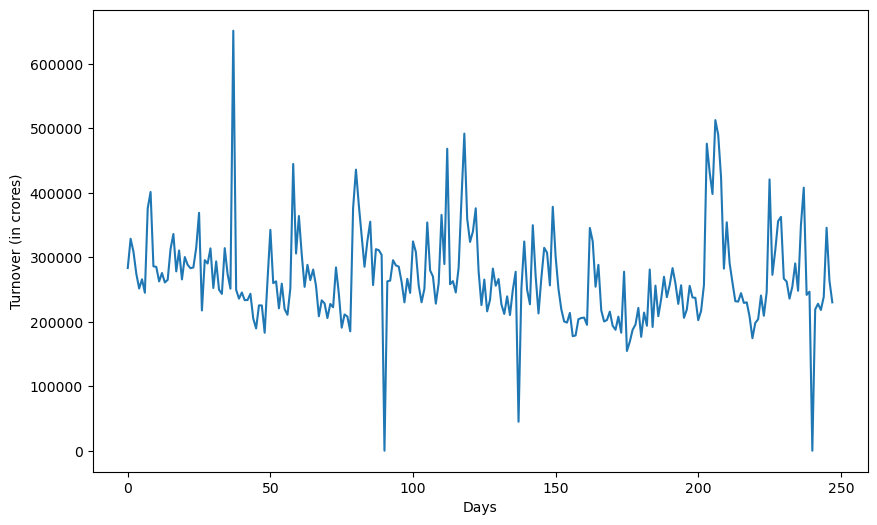

In [35]:
data = df.iloc[:,6].values
plt.figure(figsize=(10, 6))
plt.xlabel('Days')
plt.ylabel('Turnover (in crores)')
plt.plot(data)
data.shape

In [37]:
data

array([283500, 328800, 308800, 274400, 251700, 266000, 245100, 376100,
       401400, 286100, 285200, 262700, 275700, 261100, 265100, 312900,
       336200, 278200, 310600, 265800, 300500, 288400, 283100, 284300,
       314900, 369100, 217600, 295700, 290400, 313900, 252400, 293800,
       249800, 243300, 314300, 274100, 251400, 651600, 249600, 236000,
       245500, 233600, 233800, 243500, 205000, 189700, 225500, 225400,
       183000, 264700, 342600, 260000, 262800, 220900, 259200, 219600,
       210900, 251900, 444900, 306000, 364100, 304300, 254200, 288400,
       264600, 281100, 255900, 208600, 233300, 228600, 205800, 227700,
       222600, 284400, 243600, 190900, 211400, 208200, 185200, 376300,
       436100, 381500, 333600, 285400, 325000, 355300, 257000, 312700,
       311200, 303900,      0, 262800, 263900, 295600, 287600, 285600,
       262000, 230200, 266600, 244900, 324700, 308500, 256300, 230300,
       251200, 354100, 279800, 270300, 228200, 259900, 365900, 289600,
      

In [38]:
df['Date'] = pd.to_datetime(df['Date'])  
mask = (df['Date'] == '2022-7-14')
print(df.loc[mask])     # index for the date 14-July-2022
print('--------------------------------------------')
train = data[:205]
test = data[175:]
train.shape,test.shape

         Date          Open          High           Low         Close  \
69 2022-07-14  16018.849609  16070.849609  15858.200195  15938.650391   

       Adj Close  Volume  
69  15938.650391  228600  
--------------------------------------------


((205,), (73,))

In [39]:
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train.reshape(-1,1))
test = sc.transform(test.reshape(-1,1))

In [40]:
X_train = []
y_train = []
for i in range(30, train.shape[0]):
    X_train.append(train[i-30:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [41]:
print(X_train.shape, y_train.shape)
print(X_train)
print(y_train[:2])

(175, 30) (175,)
[[0.43508287 0.50460405 0.47391037 ... 0.45380602 0.44567219 0.48173726]
 [0.50460405 0.47391037 0.42111725 ... 0.44567219 0.48173726 0.38735421]
 [0.47391037 0.42111725 0.38627993 ... 0.48173726 0.38735421 0.45089012]
 ...
 [0.31921424 0.28100061 0.42618171 ... 0.36402701 0.31077348 0.33287293]
 [0.28100061 0.42618171 0.23756906 ... 0.31077348 0.33287293 0.39472069]
 [0.42618171 0.23756906 0.25936157 ... 0.33287293 0.39472069 0.73096992]]
[0.38735421 0.45089012]


In [19]:
# Training LSTM model

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
model = Sequential()
# LSTM layer
model.add(LSTM(16, input_shape=(X_train.shape[1], 1), activation='relu',kernel_initializer='lecun_uniform'))
#  Dense layer
model.add(Dense(8))
model.add(Dense(4))
model.add(Dense(2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 50, batch_size = 4)

Epoch 1/50
44/44 [==============================] - 3s 47ms/step - loss: 0.1604
Epoch 2/50
44/44 [==============================] - 2s 46ms/step - loss: 0.0140
Epoch 3/50
44/44 [==============================] - 2s 48ms/step - loss: 0.0144
Epoch 4/50
44/44 [==============================] - 2s 50ms/step - loss: 0.0141
Epoch 5/50
44/44 [==============================] - 2s 46ms/step - loss: 0.0130
Epoch 6/50
44/44 [==============================] - 2s 48ms/step - loss: 0.0122
Epoch 7/50
44/44 [==============================] - 2s 50ms/step - loss: 0.0126
Epoch 8/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0124
Epoch 9/50
44/44 [==============================] - 2s 50ms/step - loss: 0.0126
Epoch 10/50
44/44 [==============================] - 2s 48ms/step - loss: 0.0122
Epoch 11/50
44/44 [==============================] - 2s 48ms/step - loss: 0.0118
Epoch 12/50
44/44 [==============================] - 2s 45ms/step - loss: 0.0122
Epoch 13/50
44/44 [==================

In [20]:
X_test = []
y_test = []

for i in range(30, test.shape[0]):
    X_test.append(test[i-30:i, 0])
    y_test.append(test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)

(43, 30)
(175, 30, 1)


6/6 [==============================] - 0s 11ms/step


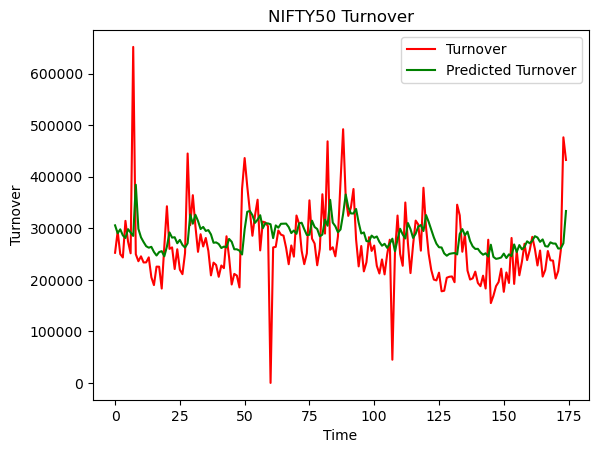

In [21]:
predicted = model.predict(X_train)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(train[-175:]), color = 'red', label = 'Turnover')
plt.plot(predicted, color = 'green', label = 'Predicted Turnover')
plt.title('NIFTY50 Turnover')
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step


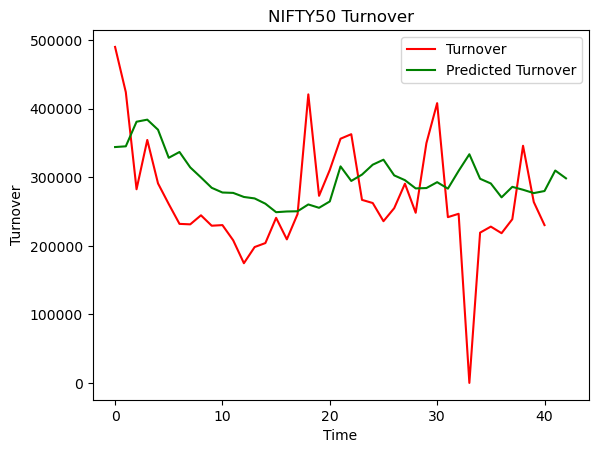

In [22]:
predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(test[-41:]), color = 'red', label = 'Turnover')
plt.plot(predicted, color = 'green', label = 'Predicted Turnover')
plt.title('NIFTY50 Turnover')
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.legend()
plt.show()